## Utilizing PyOD for Deep Learning Model Selection with GPT Few-Shot Learning

### Project Overview
This project leverages the Python Outlier Detection (PyOD) library, which encompasses a wide range of deep learning models designed for identifying outliers in multivariate data. Our goal is to use this extensive toolkit in conjunction with a language model (GPT) to intelligently select the most appropriate model for a specific dataset through a few-shot learning approach.

### Objectives
1. **Summarize Dataset and Model Information**: Compile and format detailed information about our dataset and the available models within the PyOD library into a structured form that can be easily processed by GPT.
2. **Model Selection with Language Model (LLM)**: Utilize the capabilities of GPT, trained in a few-shot learning manner, to determine the most suitable outlier detection model from the PyOD library for our dataset based on the summarized information.

### Dataset Description
The dataset involved in this project is characterized by its diversity in features and instances, providing a challenging environment to test the efficacy of various outlier detection models. Here’s a brief overview of the dataset:

| Dataset    | Domain            | Data Type    | Instances | Attributes | Missing Values | Area                    |
|------------|-------------------|--------------|-----------|------------|----------------|-------------------------|
| Arrhythmia | Medical           | Multivariate | 452       | 279        | Yes            | Cardiology              |
| Glass      | Forensic Science  | Multivariate | 214       | 9          | No             | Material Identification |
| Ionosphere | Astronomy         | Multivariate | 351       | 34         | No             | Space                   |
| Lympho     | Medical           | Multivariate | 148       | 18         | No             | Oncology                |


### PyOD Models Overview
The PyOD library includes several deep learning-based models, each with unique capabilities and configurations. The following table summarizes some of the models available for selection:

| Model      | Description                                                                                           |
|------------|-------------------------------------------------------------------------------------------------------|
| MO_GAAL    | Multiple-Objective Generative Adversarial Active Learning, suitable for complex multi-objective setups. |
| SO_GAAL    | Single-Objective Generative Adversarial Active Learning, optimized for simpler, single-objective tasks.  |
| AutoEncoder| Utilizes neural networks to learn compressed data representations, detecting anomalies based on the reconstruction errors. |
| AnoGAN     | Anomaly Detection with Generative Adversarial Networks, employs a discriminator to identify data inconsistencies. |
| DeepSVDD   | Deep Support Vector Data Description, a deep learning adaptation of the traditional SVDD method.     |
| ALAD       | Adversarially Learned Anomaly Detection, differentiates normal from abnormal data in latent space using adversarial training. |





In [1]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))
# supress warnings for clean output
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.io import loadmat


from pyod.models.mo_gaal import MO_GAAL
from pyod.models.so_gaal import SO_GAAL
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.vae import VAE
from pyod.models.anogan import AnoGAN
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.alad import ALAD
from pyod.models.ae1svm import AE1SVM
from pyod.models.devnet import DevNet
from pyod.models.rgraph import RGraph
from pyod.models.lunar import LUNAR

#AE1SVM
#DevNet
#R-Graph
#LUNAR


from pyod.utils.utility import standardizer
from pyod.utils.utility import precision_n_scores
from sklearn.metrics import roc_auc_score

In [2]:
# Define data file and read X and y
mat_file_list = ['arrhythmia.mat',
                 # 'cardio.mat',
                 'glass.mat',
                 'ionosphere.mat',
                 # 'letter.mat',
                 'lympho.mat',
                 # 'mnist.mat',
                 # 'musk.mat',
                 # 'optdigits.mat',
                 # 'pendigits.mat',
                 # 'pima.mat',
                 # 'satellite.mat',
                 # 'satimage-2.mat',
                 # 'shuttle.mat',
                 # 'vertebral.mat',
                 # 'vowels.mat',
                 # 'wbc.mat'
                 ]

# Define outlier detection tools to be compared
random_state = np.random.RandomState(42)

#待添加：VAE
df_columns = ['Data', '#Samples', '# Dimensions', 'Outlier Perc',
              'MO_GAAL', 'SO_GAAL', 'AutoEncoder', 'AnoGAN', 'DeepSVDD', 
              'ALAD', 'AE1SVM', 'DevNet', 'RGraph', 'LUNAR']
roc_df = pd.DataFrame(columns=df_columns)
prn_df = pd.DataFrame(columns=df_columns)
time_df = pd.DataFrame(columns=df_columns)

for mat_file in mat_file_list:
    print("\n... Processing", mat_file, '...')
    mat = loadmat(os.path.join('data', mat_file))

    X = mat['X']
    y = mat['y'].ravel()
    outliers_fraction = np.count_nonzero(y) / len(y)
    outliers_percentage = round(outliers_fraction * 100, ndigits=4)
    n_features = X.shape[1]

    col_means = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_means, inds[1])

    if np.isnan(X).any():
        raise ValueError("NaN values remain after attempting to replace with column means.")

    # Construct containers for saving results
    roc_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
    prn_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]
    time_list = [mat_file[:-4], X.shape[0], X.shape[1], outliers_percentage]

    # 60% data for training and 40% for testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=random_state)

    # Standardizing data for processing
    X_train_norm, X_test_norm = standardizer(X_train, X_test)

    classifiers = {
        'MO_GAAL': MO_GAAL(contamination=outliers_fraction),
        'SO_GAAL': SO_GAAL(contamination=outliers_fraction),
        'AutoEncoder': AutoEncoder(contamination=outliers_fraction),
        #'VAE': VAE(contamination=outliers_fraction),
        'AnoGAN': AnoGAN(contamination=outliers_fraction),
        'DeepSVDD': DeepSVDD(contamination=outliers_fraction, n_features=n_features),
        'ALAD': ALAD(contamination=outliers_fraction),
        'AE1SVM': AE1SVM(contamination=outliers_fraction),
        'DevNet': DevNet(contamination=outliers_fraction),
        'RGraph': RGraph(contamination=outliers_fraction),
        'LUNAR': LUNAR(contamination=outliers_fraction)
    }

    for clf_name, clf in classifiers.items():
        t0 = time()
        if clf_name == 'DevNet':
            clf.fit(X_train_norm, X_test)
        else:
            clf.fit(X_train_norm)
        test_scores = clf.decision_function(X_test_norm)
        t1 = time()
        duration = round(t1 - t0, ndigits=4)
        time_list.append(duration)

        roc = round(roc_auc_score(y_test, test_scores), ndigits=4)
        prn = round(precision_n_scores(y_test, test_scores), ndigits=4)

        print(f'{clf_name} ROC: {roc}, precision @ rank n: {prn}, execution time: {duration}s')

        roc_list.append(roc)
        prn_list.append(prn)

    temp_df = pd.DataFrame(time_list).transpose()
    temp_df.columns = df_columns
    time_df = pd.concat([time_df, temp_df], axis=0)

    temp_df = pd.DataFrame(roc_list).transpose()
    temp_df.columns = df_columns
    roc_df = pd.concat([roc_df, temp_df], axis=0)

    temp_df = pd.DataFrame(prn_list).transpose()
    temp_df.columns = df_columns
    prn_df = pd.concat([prn_df, temp_df], axis=0)


... Processing arrhythmia.mat ...
Epoch 1 of 60
Epoch 2 of 60
Epoch 3 of 60
Epoch 4 of 60
Epoch 5 of 60
Epoch 6 of 60
Epoch 7 of 60
Epoch 8 of 60
Epoch 9 of 60
Epoch 10 of 60
Epoch 11 of 60
Epoch 12 of 60
Epoch 13 of 60
Epoch 14 of 60
Epoch 15 of 60
Epoch 16 of 60
Epoch 17 of 60
Epoch 18 of 60
Epoch 19 of 60
Epoch 20 of 60
Epoch 21 of 60
Epoch 22 of 60
Epoch 23 of 60
Epoch 24 of 60
Epoch 25 of 60
Epoch 26 of 60
Epoch 27 of 60
Epoch 28 of 60
Epoch 29 of 60
Epoch 30 of 60
Epoch 31 of 60
Epoch 32 of 60
Epoch 33 of 60
Epoch 34 of 60
Epoch 35 of 60
Epoch 36 of 60
Epoch 37 of 60
Epoch 38 of 60
Epoch 39 of 60
Epoch 40 of 60
Epoch 41 of 60
Epoch 42 of 60
Epoch 43 of 60
Epoch 44 of 60
Epoch 45 of 60
Epoch 46 of 60
Epoch 47 of 60
Epoch 48 of 60
Epoch 49 of 60
Epoch 50 of 60
Epoch 51 of 60
Epoch 52 of 60
Epoch 53 of 60
Epoch 54 of 60
Epoch 55 of 60
Epoch 56 of 60
Epoch 57 of 60
Epoch 58 of 60
Epoch 59 of 60
Epoch 60 of 60
MO_GAAL ROC: 0.6153, precision @ rank n: 0.3214, execution time: 2.2194s
E

Training: 100%|██████████| 10/10 [00:00<00:00, 18.70it/s]


AutoEncoder ROC: 0.8096, precision @ rank n: 0.3929, execution time: 3.1156s
AnoGAN ROC: 0.7726, precision @ rank n: 0.4286, execution time: 52.4219s
Epoch 1/100, Loss: 5.825584053993225
Epoch 2/100, Loss: 5.766186058521271
Epoch 3/100, Loss: 5.762155622243881
Epoch 4/100, Loss: 5.853882700204849
Epoch 5/100, Loss: 5.786322772502899
Epoch 6/100, Loss: 5.646298587322235
Epoch 7/100, Loss: 5.793177425861359
Epoch 8/100, Loss: 5.740046471357346
Epoch 9/100, Loss: 5.9401843547821045
Epoch 10/100, Loss: 5.7085913717746735
Epoch 11/100, Loss: 5.576205193996429
Epoch 12/100, Loss: 5.7851404547691345
Epoch 13/100, Loss: 5.77113077044487
Epoch 14/100, Loss: 5.7520412504673
Epoch 15/100, Loss: 5.915862739086151
Epoch 16/100, Loss: 5.660930097103119
Epoch 17/100, Loss: 5.639804899692535
Epoch 18/100, Loss: 5.746669828891754
Epoch 19/100, Loss: 5.6973293125629425
Epoch 20/100, Loss: 5.6578125059604645
Epoch 21/100, Loss: 5.895969212055206
Epoch 22/100, Loss: 6.077497363090515
Epoch 23/100, Loss: 5

Training: 100%|██████████| 10/10 [00:00<00:00, 51.81it/s]


AutoEncoder ROC: 0.561, precision @ rank n: 0.0, execution time: 0.2098s
AnoGAN ROC: 0.628, precision @ rank n: 0.0, execution time: 13.7568s
Epoch 1/100, Loss: 3.2010475993156433
Epoch 2/100, Loss: 3.2010475397109985
Epoch 3/100, Loss: 3.2010475993156433
Epoch 4/100, Loss: 3.2010475993156433
Epoch 5/100, Loss: 3.2010475993156433
Epoch 6/100, Loss: 3.201047658920288
Epoch 7/100, Loss: 3.2010475397109985
Epoch 8/100, Loss: 3.201047658920288
Epoch 9/100, Loss: 3.2010475993156433
Epoch 10/100, Loss: 3.201047658920288
Epoch 11/100, Loss: 3.2010475993156433
Epoch 12/100, Loss: 3.2010474801063538
Epoch 13/100, Loss: 3.2010475993156433
Epoch 14/100, Loss: 3.201047658920288
Epoch 15/100, Loss: 3.2010475993156433
Epoch 16/100, Loss: 3.2010475397109985
Epoch 17/100, Loss: 3.201047658920288
Epoch 18/100, Loss: 3.2010475397109985
Epoch 19/100, Loss: 3.201047658920288
Epoch 20/100, Loss: 3.201047658920288
Epoch 21/100, Loss: 3.2010475397109985
Epoch 22/100, Loss: 3.2010474801063538
Epoch 23/100, Lo

Training: 100%|██████████| 10/10 [00:00<00:00, 35.32it/s]


AutoEncoder ROC: 0.8435, precision @ rank n: 0.6522, execution time: 0.3043s
AnoGAN ROC: 0.7895, precision @ rank n: 0.5652, execution time: 24.3891s
Epoch 1/100, Loss: 7.921357691287994
Epoch 2/100, Loss: 8.030775845050812
Epoch 3/100, Loss: 8.10765814781189
Epoch 4/100, Loss: 7.986689925193787
Epoch 5/100, Loss: 7.972405552864075
Epoch 6/100, Loss: 8.013543665409088
Epoch 7/100, Loss: 8.173039436340332
Epoch 8/100, Loss: 8.132040560245514
Epoch 9/100, Loss: 8.053748488426208
Epoch 10/100, Loss: 8.158176898956299
Epoch 11/100, Loss: 8.000537633895874
Epoch 12/100, Loss: 7.931086182594299
Epoch 13/100, Loss: 8.042643427848816
Epoch 14/100, Loss: 8.279706358909607
Epoch 15/100, Loss: 7.955238521099091
Epoch 16/100, Loss: 8.147838830947876
Epoch 17/100, Loss: 8.23161506652832
Epoch 18/100, Loss: 8.068905115127563
Epoch 19/100, Loss: 8.19365644454956
Epoch 20/100, Loss: 7.965809404850006
Epoch 21/100, Loss: 7.936765968799591
Epoch 22/100, Loss: 8.340260207653046
Epoch 23/100, Loss: 8.0941

Training: 100%|██████████| 10/10 [00:00<00:00, 102.52it/s]


AutoEncoder ROC: 1.0, precision @ rank n: 1.0, execution time: 0.112s
AnoGAN ROC: 1.0, precision @ rank n: 1.0, execution time: 9.4266s
Epoch 1/100, Loss: 2.2078898549079895
Epoch 2/100, Loss: 2.213684618473053
Epoch 3/100, Loss: 2.185956060886383
Epoch 4/100, Loss: 2.2086670994758606
Epoch 5/100, Loss: 2.2030729055404663
Epoch 6/100, Loss: 2.221741259098053
Epoch 7/100, Loss: 2.2205770015716553
Epoch 8/100, Loss: 2.1961257457733154
Epoch 9/100, Loss: 2.237293064594269
Epoch 10/100, Loss: 2.1748898029327393
Epoch 11/100, Loss: 2.2146159410476685
Epoch 12/100, Loss: 2.201032519340515
Epoch 13/100, Loss: 2.210383653640747
Epoch 14/100, Loss: 2.2095858454704285
Epoch 15/100, Loss: 2.182273507118225
Epoch 16/100, Loss: 2.215256690979004
Epoch 17/100, Loss: 2.218577742576599
Epoch 18/100, Loss: 2.2309000492095947
Epoch 19/100, Loss: 2.182823419570923
Epoch 20/100, Loss: 2.2528615593910217
Epoch 21/100, Loss: 2.169226288795471
Epoch 22/100, Loss: 2.197996437549591
Epoch 23/100, Loss: 2.21639

In [13]:
print('Time complexity')
time_df

Time complexity


,Data,#Samples,# Dimensions,Outlier Perc,MO_GAAL,SO_GAAL,AutoEncoder,AnoGAN,DeepSVDD,ALAD,AE1SVM,DevNet,RGraph,LUNAR
0,arrhythmia,452,274,14.6018,2.2194,0.7724,3.1156,52.4219,0.6767,3.3174,4.6475,52.4647,386.0246,4.632
0,glass,214,9,4.2056,0.5026,0.137,0.2098,13.7568,0.1831,1.9788,1.8763,0.2086,4.1631,3.702
0,ionosphere,351,33,35.8974,0.5761,0.2449,0.3043,24.3891,0.2843,2.0203,3.1278,1.6063,49.7426,3.5511
0,lympho,148,18,4.0541,0.4787,0.0963,0.112,9.4266,0.1654,2.153,1.5269,0.6124,3.0226,3.2403


Analyze the performance of ROC and Precision @ n

In [14]:
print('ROC Performance')
roc_df

ROC Performance


,Data,#Samples,# Dimensions,Outlier Perc,MO_GAAL,SO_GAAL,AutoEncoder,AnoGAN,DeepSVDD,ALAD,AE1SVM,DevNet,RGraph,LUNAR
0,arrhythmia,452,274,14.6018,0.6153,0.6179,0.8096,0.7726,0.7915,0.5257,0.818,0.4288,0.7241,0.8284
0,glass,214,9,4.2056,0.686,0.4756,0.561,0.628,0.4573,0.5305,0.6189,0.5335,0.5274,0.6707
0,ionosphere,351,33,35.8974,0.7789,0.4838,0.8435,0.7895,0.832,0.4579,0.8872,0.7227,0.2331,0.9172
0,lympho,148,18,4.0541,0.4971,0.3977,1.0,1.0,0.9766,0.4503,1.0,0.0058,0.6316,0.9708


In [36]:
roc_df.to_csv('roc_df.csv')

''' 
answer from llm:
- arrhythmia: AutoEncoder/vae
- glass: mogaal/sogaal
- ionosphere: auto/vae
- lympho: mogaal/sogaal
'''

In [15]:
print('Precision @ n Performance')
prn_df

Precision @ n Performance


,Data,#Samples,# Dimensions,Outlier Perc,MO_GAAL,SO_GAAL,AutoEncoder,AnoGAN,DeepSVDD,ALAD,AE1SVM,DevNet,RGraph,LUNAR
0,arrhythmia,452,274,14.6018,0.3214,0.3571,0.3929,0.4286,0.4286,0.0714,0.3929,0.2143,0.3571,0.4643
0,glass,214,9,4.2056,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0,ionosphere,351,33,35.8974,0.6739,0.3261,0.6522,0.5652,0.6304,0.2609,0.6304,0.5435,0.0,0.8696
0,lympho,148,18,4.0541,0.3333,0.3333,1.0,1.0,0.6667,0.0,1.0,0.0,0.0,0.6667


## Summarize model/dataset features

In [16]:
import pandas as pd

In [17]:
# 数据集信息
data_info = {
    "Dataset": ["arrhythmia", "glass", "ionosphere", "lympho"],
    "Domain": ["Medical", "Forensic Science", "Astronomy", "Medical"],
    "Data Type": ["Multivariate", "Multivariate", "Multivariate", "Multivariate"],
    "Number of Instances": [452, 214, 351, 148],
    "Number of Attributes": [279, 9, 34, 18],
    "Missing Values": ["Yes", "No", "No", "No"],
    "Area": ["Cardiology", "Material Identification", "Space", "Oncology"]
}

# 创建 DataFrame
df = pd.DataFrame(data_info)

# 将 DataFrame 保存为 CSV 文件
csv_file_path = 'dataset_hyperparam.csv'
df.to_csv(csv_file_path, index=False)


In [18]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import os

def calculate_descriptive_statistics(data_path, dataset_names):
    stats = []
    for dataset in dataset_names:
        mat = loadmat(os.path.join(data_path, dataset))
        X = mat['X']
        y = mat['y'].ravel()
        
        # 计算统计数据
        mean_vals = np.mean(X, axis=0)
        std_devs = np.std(X, axis=0)
        min_vals = np.min(X, axis=0)
        max_vals = np.max(X, axis=0)
        
        # 计算整体描述性统计
        overall_stats = {
            'mean': np.mean(mean_vals),
            'std_dev': np.mean(std_devs),
            'min': np.min(min_vals),
            'max': np.max(max_vals)
        }
        stats.append(overall_stats)
    return stats


data_path = 'data'
stats = calculate_descriptive_statistics(data_path, mat_file_list)


In [19]:
df = pd.DataFrame(data_info)

# 将统计数据加入 DataFrame
for i, stat in enumerate(stats):
    df.loc[i, 'Mean'] = stat['mean']
    df.loc[i, 'Std Dev'] = stat['std_dev']
    df.loc[i, 'Min'] = stat['min']
    df.loc[i, 'Max'] = stat['max']

print(df)
df.to_csv('updated_dataset_information.csv', index=False)

# 对照试验？提供哪些信息准确率更高


      Dataset            Domain     Data Type  Number of Instances  \
0  arrhythmia           Medical  Multivariate                  452   
1       glass  Forensic Science  Multivariate                  214   
2  ionosphere         Astronomy  Multivariate                  351   
3      lympho           Medical  Multivariate                  148   

   Number of Attributes Missing Values                     Area       Mean  \
0                   279            Yes               Cardiology  10.125108   
1                     9             No  Material Identification  11.265852   
2                    34             No                    Space   0.255203   
3                    18             No                 Oncology   2.074700   

    Std Dev    Min     Max  
0  6.546009 -242.4  780.00  
1  0.687928    0.0   75.41  
2  0.525138   -1.0    1.00  
3  0.699778    1.0    8.00  


In [25]:
#model信息1：code details

code_summaries = {
    'MO-GAAL': """
1. MO-GAAL (Multiple Objective Generative Adversarial Active Learning) is an outlier detection algorithm based on Generative Adversarial Networks (GANs). It uses multiple sub-generators, each with different objectives, to generate outliers, aiding in separating outliers from normal data. This also helps avoid mode collapse, where the generator produces limited sample variety. The model uses a discriminator to distinguish between real and generated outliers and a generator to produce potential outliers.

2. Advantages include its ability to discover complex outlier structures and improve detection performance, overcoming mode collapse. Disadvantages include the computational expense of training multiple GANs and the need for careful hyperparameter tuning. It may lack interpretability, as deep learning models often act as black boxes.

3. MO-GAAL performs well on high-dimensional data with complex patterns. However, it may be excessive for simpler datasets where more efficient methods could suffice, and it may not be suitable when interpretability is critical.
""",
    
    'SO-GAAL': """
1. SO-GAAL (Single-Objective Generative Adversarial Active Learning) is an outlier detection model using a GAN setup with one generator and one discriminator. The generator produces synthetic data, while the discriminator distinguishes between real and generated data. The model uses generated examples as potential outliers to learn boundaries between normal data and outliers.

2. Its advantages include dynamic learning and adaptability, especially when outliers are rare. However, the model may suffer from mode collapse, generating overly similar or 'good' examples, which could limit its effectiveness.

3. SO-GAAL works well on datasets with rare outliers or complex feature structures but may struggle when outliers cannot be well approximated by the generator or when there are only minor distinctions between normal and outlier data.
""",
    
    'AutoEncoder': """
1. This model is based on an AutoEncoder, a neural network used for unsupervised data representation learning. It compresses input data into a low-dimensional code via an encoder and reconstructs it through a decoder. Outliers are detected based on their reconstruction errors, as they typically deviate from normal instances. The model uses ReLU activation, dropout, and batch normalization to prevent overfitting.

2. AutoEncoders are unsupervised and adaptable, making them versatile across various datasets. However, they are sensitive to hyperparameter selection and may struggle to preserve global data structures.

3. AutoEncoders perform well on structured data like images or sequences but may struggle on noisy or scalar data with no inherent structure, where simpler methods could be more efficient.
""",
    
    'AnoGAN': """
1. AnoGAN uses GANs for outlier detection, with a generator and discriminator. It uses standard GAN training followed by training a separate query model to find the closest latent space point for each data instance. Outliers are detected based on their reconstruction error in the latent space.

2. AnoGAN is effective for modeling complex, high-dimensional data and handles both numerical and categorical data. However, it is computationally expensive, and GAN training is known to be unstable.

3. AnoGAN excels on complex datasets like images or medical scans but may struggle with simpler or imbalanced datasets, where traditional outlier detection methods might be more appropriate.
""",
    
    'Deep SVDD': """
1. Deep SVDD aims to minimize the volume of a hypersphere enclosing the network representations of data during training. It detects outliers by measuring the distance from the center. The architecture is customizable, allowing users to define the network layers and activation functions. It can also operate in autoencoder mode, where the encoder-decoder structure mirrors itself.

2. Advantages include unsupervised learning, flexibility in network architecture, and regularization options like dropout and L2. Disadvantages involve the need for trial-and-error hyperparameter tuning and the requirement of large datasets for effective training.

3. Deep SVDD performs well on datasets with identifiable patterns but struggles with noisy, imbalanced, or complex datasets where outliers are not easily separable from normal data.
""",
    
    'ALAD': """
1. ALAD uses a GAN architecture with an encoder, a generator, and three discriminators to distinguish real from generated data. The model can also incorporate reconstruction loss for improved performance.

2. ALAD excels at detecting complex patterns and works well on high-dimensional data. However, it requires substantial computational resources and may perform poorly when the data distribution is difficult to learn or when the dataset is small.

3. ALAD is effective for complex, high-dimensional datasets but may struggle with small or simple datasets, where traditional methods might be more efficient.
""",

    'AE1SVM' : """

1. This model combines an Autoencoder (AE) with a One-Class Support Vector Machine (SVM) to detect outliers. The Autoencoder learns a compressed representation of the data through encoding and decoding layers, while the One-Class SVM works on the encoded data's random Fourier features to separate normal data from outliers. The architecture uses hidden layers with customizable neurons, ReLU activations, batch normalization, and dropout for regularization. By utilizing random Fourier features in the SVM, it approximates a kernel function, allowing for non-linear decision boundaries to better distinguish outliers.

2. Advantages: The model can capture complex data patterns through the Autoencoder's deep structure and the SVM’s non-linear decision boundaries, providing enhanced outlier detection in non-linearly separable data. Batch normalization and dropout improve training stability and prevent overfitting. Disadvantages: It is computationally expensive, especially with a large number of random Fourier features. Training this model may be time-consuming due to the Autoencoder and SVM combination, which could also make it less effective on small datasets or real-time applications.

3. Good performance: This model is ideal for large datasets with high dimensionality and complex, non-linear patterns, where normal and anomalous data have distinguishable structures. Poor performance: It may perform poorly on small datasets, highly noisy datasets, or data with simple, linear separations between normal and anomalous points, as the model's complexity could lead to overfitting or unnecessary computation.
""",

    'DevNet' : """

1. DevNet's architecture varies in depth with options for shallow or deep networks, which include three specific models: DevNetD (3 hidden layers), DevNetS (1 hidden layer), and DevNetLinear (no hidden layer). These configurations allow flexible model complexity based on data needs. Each hidden layer uses ReLU activations, which helps capture non-linear patterns in the data. The model uses a specialized deviation loss, which applies Z-score deviation based on the assumption that inliers and outliers deviate from a reference distribution differently, optimizing the model to distinguish between them effectively.

2. Advantages: The flexibility of choosing the network depth makes it adaptable to various data complexities. The deviation loss function is tailored for outlier detection, providing direct optimization for distinguishing anomalies from normal instances. Disadvantages: Deep models, such as DevNetD, could overfit on small datasets with limited diversity, potentially reducing generalizability. The model may struggle with datasets containing subtle or high-dimensional anomalies that are hard to capture with simple linear layers. Training a deep network can be computationally expensive and requires considerable tuning, especially on larger datasets.

3. Good Performance: DevNet will likely perform well on datasets where the outliers exhibit distinct characteristics from the inliers, particularly if the data is moderately complex with features that can be captured by shallow or deep neural networks (e.g., low-dimensional structured data or data with clear, distinguishable outlier patterns). Poor Performance: The model might struggle on high-dimensional datasets where anomalies are subtle and require more sophisticated feature extraction than linear layers can provide. Additionally, if the outliers do not significantly deviate from the inliers, the deviation-based loss function may not effectively identify them.
""",

    'RGraph' : """

1. The RGraph model uses an elastic net subspace clustering technique with a graph-based transition matrix to represent data self-representation and outlier scoring. It combines elements of sparse representation (via the Lasso and linear regression) and an active support strategy to optimize computations, especially for large datasets. It detects outliers by constructing a transition matrix normalized by L1, followed by transition steps that propagate a probability vector through this matrix. Lower scores from this transition process signify outliers.

2. Advantages: It handles high-dimensional data well due to its reliance on sparse representations. The active support algorithm can optimize the process, making it scalable for large datasets. Disadvantages: The model may be computationally intensive, especially if the active support is not correctly tuned, as it iteratively solves optimization problems. Sensitivity to hyperparameters (like tau, gamma) can make the model difficult to tune, potentially impacting performance on noisy data.

3. Good performance: This model should perform well on high-dimensional, sparse datasets where data points reside in low-dimensional subspaces (e.g., image or signal data with natural clusters). Poor performance: It may struggle on dense, low-dimensional datasets with strong non-linear relationships, as its linear clustering technique might not capture complex patterns, potentially leading to poor outlier identification.
""",

    'LUNAR' : """

1. The LUNAR model uses graph neural networks to unify local outlier detection methods by leveraging nearest neighbors. Its architecture consists of two neural networks, SCORE_MODEL and WEIGHT_MODEL, each with three hidden layers of 256 units. The activation functions differ: SCORE_MODEL uses Tanh activations and a Sigmoid output, while WEIGHT_MODEL uses ReLU activations with a final layer normalizing weights via LayerNorm and BatchNorm. LUNAR generates anomaly scores by evaluating the distance between data points and their nearest neighbors and employs a unique negative sampling approach, using random uniform and subspace perturbations to simulate outliers.

2. Advantages: Flexibility: LUNAR's dual model approach allows for adaptability in scoring based on different types of outliers. Local Context Awareness: By focusing on k-nearest neighbors, it effectively captures local data structures, which can improve the detection of local outliers. Robust Sampling: The negative sampling technique enhances training by simulating diverse outlier types, potentially improving detection accuracy. Disadvantages: Computationally Intensive: The model’s reliance on neural networks and nearest neighbor searches could lead to high computational costs, particularly on large datasets. Hyperparameter Sensitivity: Its performance is likely sensitive to parameters like n_neighbors, sampling proportion, and model type, which may require fine-tuning for optimal results.

3. Good Performance: The model will likely excel on datasets with well-defined clusters or local structures where outliers are distinct from the majority class. Examples include structured datasets like social network data, sensor data, and geospatial data. Poor Performance: LUNAR may struggle on high-dimensional or noisy datasets where local neighborhood relationships are less meaningful or when the data is too sparse, making it difficult to discern local outliers effectively.
"""
}


In [26]:
#model信息2：paper summarize

#model信息2：paper summarize

paper_summaries = {
    'MO-GAAL': "MO-GAAL addresses the limitations of SO-GAAL by using multiple generators, each tasked with generating different types of outliers. This approach mitigates the mode collapse problem by creating a mixture of reference distributions, enabling more robust and accurate outlier detection across datasets with various data types and dimensions",
    
    'SO-GAAL': "SO-GAAL generates potential outliers using a single generator in a Generative Adversarial Network (GAN) framework, which plays a mini-max game with a discriminator. The generator synthesizes informative outliers that help the discriminator distinguish between normal data and anomalies. However, SO-GAAL can suffer from mode collapse, where the generator fails to provide diverse enough outliers, limiting its detection ability",
    
    'AutoEncoder': "AutoEncoder is a neural network model primarily used for unsupervised anomaly detection. It works by encoding input data into a lower-dimensional latent space and then reconstructing it back into the original space. Anomalies are detected by measuring the reconstruction error: normal data is reconstructed with minimal error, while anomalies yield higher reconstruction errors. AutoEncoder is particularly suited for structured and tabular data, and its performance can be tuned by adjusting the network’s architecture, including the number of hidden layers and nodes. It is effective for detecting subtle anomalies in complex datasets.",
    
    'AnoGAN': "AnoGAN is an unsupervised learning model that detects anomalies by learning a representation of normal data using a Generative Adversarial Network (GAN). It identifies anomalies by mapping new data to a latent space and calculating how well the new data fits within the learned normal distribution. The model is particularly effective for image-based anomaly detection and was initially applied to medical imaging, where it detects anomalous regions that deviate from the learned healthy patterns.",
    
    'Deep SVDD': "DeepSVDD is a deep learning-based anomaly detection method that extends the classical SVDD (Support Vector Data Description) approach. It learns a compact representation of the data by mapping input samples to a hypersphere of minimum volume in a feature space. The goal is to enclose normal data within the hypersphere, while outliers are mapped outside of it. DeepSVDD avoids the need for explicit feature engineering and works effectively on high-dimensional data, particularly image datasets. It is trained using a one-class objective to ensure that the majority of normal data is close to the hypersphere center, making it suitable for unsupervised anomaly detection.",
    
    'ALAD': "ALAD is a GAN-based anomaly detection method that incorporates an encoder and discriminator to learn a latent representation of normal data. It leverages bi-directional GANs and cycle-consistency to map data samples to and from a latent space, enabling faster and more accurate anomaly detection. ALAD focuses on improving reconstruction error for anomaly detection by utilizing adversarially learned features, ensuring that both the data space and the latent space are well represented. This method enhances performance and stability, particularly in high-dimensional datasets, and is much faster at inference than traditional GAN-based methods",
    
    'AE1SVM': "AE1SVM (Autoencoder-based One-Class SVM) combines an autoencoder with a one-class support vector machine (OC-SVM) for anomaly detection in high-dimensional datasets. The autoencoder is used for dimensionality reduction, while OC-SVM detects anomalies in the reduced space. To handle non-linear data, AE1SVM employs random Fourier features (RFF) to approximate the RBF kernel, enabling efficient training via stochastic gradient descent (SGD). This integration allows for scalable anomaly detection and interpretable results. The autoencoder is optimized to produce representations that help the OC-SVM distinguish between normal and anomalous data. Gradient-based methods provide interpretability by highlighting influential features contributing to the model’s decisions.",
    
    "DevNet": "DevNet (Deviation Networks) is an anomaly detection model that combines feature learning with anomaly detection in an end-to-end framework. It introduces a Z-Score-based deviation loss, which enforces significant deviations between the anomaly scores of normal and anomalous data points. DevNet uses a small number of labeled anomalies and assumes a Gaussian prior distribution for anomaly scores, ensuring that anomalies stand out from normal data. This approach improves data efficiency and interpretability, outperforming traditional methods, especially when labeled anomalies are limited. DevNet achieves superior results in metrics like AUC-ROC and AUC-PR.",
    
    "LUNAR": "LUNAR (Learnable Unified Neighbourhood-based Anomaly Ranking) is an anomaly detection model that unifies local outlier detection methods (such as LOF, KNN, and DBSCAN) using a graph neural network (GNN) framework. Traditional local outlier methods measure the distance of a sample to its nearest neighbors to detect anomalies, but they lack the ability to learn and adapt to a specific dataset. LUNAR introduces learnability into this framework by leveraging a GNN, which aggregates neighborhood information in a trainable way. This makes LUNAR more flexible and robust compared to traditional methods, allowing it to outperform both classical and deep learning-based anomaly detection techniques, particularly in scenarios with varying neighborhood sizes.",
    
    "RGraph" : "R-Graph (Representation Graph) is an anomaly detection method that combines data self-representation with random walks on a directed graph. The method is designed to identify outliers in high-dimensional datasets by leveraging the fact that inliers can be represented as sparse combinations of other inliers, while outliers use both inliers and outliers in their representations. By constructing an asymmetric affinity matrix and defining a Markov Chain on the resulting graph, R-Graph detects outliers based on the behavior of random walks. Outliers are identified as those points for which the random walk probabilities tend to zero. The method has theoretical guarantees for correctness under certain geometric and connectivity assumptions, and experimental results demonstrate its effectiveness compared to state-of-the-art methods for outlier detection in multiple subspaces." 
}

In [27]:
#model信息3：hyperparams
import pandas as pd

model_hyperparams = pd.read_csv('Hyperparameter_Configuration.csv')
dataset_hyperparams = pd.read_csv('dataset_hyperparam.csv')
model_hyperparams

,Pipeline Design Dimensions,MO-GAAL,SO-GAAL,AutoEncoder,VAE,AnoGAN,Deep SVDD,ALAD,RGraph,DevNet,AE1SVM,LUNAR
0,Data Augmentation,"SMOTE, GAN-based Oversampling","Oversampling, GAN-based Augmentation",NaN,NaN,NaN,NaN,NaN,Graph-based Embedding,Anomaly Injection,Feature Augmentation,Latent Space Manipulation
1,Data Preprocessing,"Normalization, Standardization","MinMax Scaling, Standardization","StandardScaler, Normalization","StandardScaler, MinMax Scaling","StandardScaler, MinMax Scaling","StandardScaler, MinMax Scaling","StandardScaler, MinMax Scaling",Graph Normalization,"StandardScaler, Normalization","StandardScaler, MinMax Scaling","Normalization, MinMax Scaling"
2,Network Architecture,"Discriminator, Generator (GAN), MLP, AutoEncoder","Discriminator, Generator (GAN)","AutoEncoder, MLP","VAE, beta-VAE, AutoEncoder","Discriminator, Generator (GAN)","AutoEncoder, One-Class Classifier","Discriminator, Generator (GAN)","Graph Neural Network, R-GCN","MLP, Fully Connected Network",AutoEncoder + SVM,"Latent Variable Model, VAE-based"
3,Hidden Layers,"[[32, 16], [64, 32, 16], [128, 64, 32, 16]]","[[64, 32], [128, 64, 32], [256, 128, 64, 32]]","[[32, 16], [64, 32, 16], [128, 64, 32, 16]]","[[64, 32], [128, 64, 32], [256, 128, 64]]","[[64, 32], [128, 64, 32], [256, 128, 64, 32]]","[[64, 32], [128, 64, 32], [256, 128, 64, 32]]","[[64, 32], [128, 64, 32], [256, 128, 64]]","[[64, 32], [128, 64, 32]]","[[32, 16], [64, 32], [128, 64, 32]]","[[64, 32], [128, 64, 32]]","[[32, 16], [64, 32, 16]]"
4,Activation,"ReLU, LeakyReLU, Tanh","ReLU, LeakyReLU, Tanh","ReLU, Tanh, LeakyReLU","ReLU, Tanh, LeakyReLU","ReLU, LeakyReLU, Tanh","ReLU, Tanh, LeakyReLU","ReLU, LeakyReLU, Tanh","ReLU, Tanh","ReLU, LeakyReLU","ReLU, Tanh","ReLU, LeakyReLU"
5,Dropout,0.5,0.5,0.2,0.3,0.4,0.5,0.4,0.5,0.3,0.2,0.4
6,Initialization,Xavier Uniform,Xavier Uniform,Xavier Normal,Xavier Normal,Xavier Uniform,Xavier Uniform,Xavier Uniform,Xavier Uniform,He Normal,Xavier Normal,Xavier Uniform
7,Loss Function,Cross-Entropy Loss,Cross-Entropy Loss,Reconstruction Loss,Reconstruction Loss + KL Divergence,Cross-Entropy Loss,Binary Cross-Entropy,Cross-Entropy Loss,Cross-Entropy Loss,Binary Cross-Entropy,One-Class SVM Loss,Reconstruction Loss + KL Divergence
8,Optimizer,Adam,Adam,Adam,AdamW,Adam,Adam,Adam,Adam,SGD,Adam,AdamW
9,Epochs,100,100,200,120,150,150,100,100,150,200,120


In [29]:
# 函数：将数据集信息转换为自然语言描述
def dataset_to_natural_language(df):
    dataset_prompt_list = []
    for index, row in df.iterrows():
        description = (
            f"The {row['Dataset']} dataset is commonly used in the {row['Domain']} domain. "
            f"It is a {row['Data Type']} dataset with {row['Number of Instances']} instances "
            f"and {row['Number of Attributes']} attributes. "
            f"Areas of application include {row['Area']}, and it {'' if row['Missing Values'] == 'No' else 'does '}contain missing values."
        )
        dataset_prompt_list.append(description)
    return dataset_prompt_list

def model_to_natural_language(df, paper_summaries, code_summaries):
    model_prompt_list = []
    for column in paper_summaries.keys():  
        description = f"Model '{column}' hyperparameters include: "
        
        for index, row in df.iterrows():
            description += f"{row['Pipeline Design Dimensions']}: {row[column]}, "
        description = description.strip(", ")

        # 添加 paper_summaries 的描述
        if column in paper_summaries:
            description += f"\n\nPaper summary for {column}: {paper_summaries[column]}"

        # 添加 code_summaries 的描述
        if column in code_summaries:
            description += f"\n\nCode summary for {column}: {code_summaries[column]}"

        model_prompt_list.append(description)
    
    return model_prompt_list



dataset_prompt_list = dataset_to_natural_language(dataset_hyperparams)

model_prompt_list = model_to_natural_language(model_hyperparams, paper_summaries, code_summaries)

# 输出或返回列表
print(dataset_prompt_list)
print(model_prompt_list)


['The arrhythmia dataset is commonly used in the Medical domain. It is a Multivariate dataset with 452 instances and 279 attributes. Areas of application include Cardiology, and it does contain missing values.', 'The glass dataset is commonly used in the Forensic Science domain. It is a Multivariate dataset with 214 instances and 9 attributes. Areas of application include Material Identification, and it contain missing values.', 'The ionosphere dataset is commonly used in the Astronomy domain. It is a Multivariate dataset with 351 instances and 34 attributes. Areas of application include Space, and it contain missing values.', 'The lympho dataset is commonly used in the Medical domain. It is a Multivariate dataset with 148 instances and 18 attributes. Areas of application include Oncology, and it contain missing values.']
["Model 'MO-GAAL' hyperparameters include: Data Augmentation: SMOTE, GAN-based Oversampling, Data Preprocessing: Normalization, Standardization, Network Architecture:

## Use GPT to select proper model

In [30]:
from openai import OpenAI
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv("API_KEY")

client = OpenAI(api_key=api_key)
def create_prompt(dataset_description, model_descriptions):
    prompt = f"Given the dataset with the following characteristics:\n{dataset_description}\n\n"
    prompt += "Here are the available models and their hyperparameters:\n"
    for model_description in model_descriptions:
        prompt += f"{model_description}\n"
    prompt += "\nGiven this information, which is the BEST ONE would you recommend using for this dataset? Please only choose the best one."
    return prompt

def call_gpt(prompt):
    messages = [
        {"role": "system", "content": 'You are a well-trained data scientist specifically good at machine learning.'},
        {"role": "user", "content": prompt}
    ]
    response = client.chat.completions.create(
        model="gpt-4",
        messages=messages,
        max_tokens=1000
    ).choices[0].message.content
    return response


In [31]:
raw_resp_dict = {}
results_dict = {}

for run in range(10):  # 运行10次
    print(f"Running iteration {run + 1}/10")
    for dataset_description in dataset_prompt_list:
        overall_prompt = create_prompt(dataset_description, model_prompt_list)
        response_raw = call_gpt(overall_prompt)
        processing_prompt = 'Please return me the name (only the top one) of recommended best model (Which is supposed to be one of these models : MO-GAAL,AutoEncoder,SO-GAAL,VAE,AnoGAN,Deep SVDD,ALAD,AE1SVM,DevNet,RGraph, LUNAR) given the paragraph below, in form of python list: \n' + response_raw
        response = call_gpt(processing_prompt)
        dataset_name = dataset_description.split(" ")[1]
        if dataset_name not in raw_resp_dict:
            raw_resp_dict[dataset_name] = []
        if dataset_name not in results_dict:
            results_dict[dataset_name] = []
        raw_resp_dict[dataset_name].append(response_raw)
        results_dict[dataset_name].append(response)

# 将结果转换为DataFrame
# 对于 raw_resp_dict
raw_resp_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in raw_resp_dict.items()]))
raw_resp_df.index += 1  

Running iteration 1/10
Running iteration 2/10
Running iteration 3/10
Running iteration 4/10
Running iteration 5/10
Running iteration 6/10
Running iteration 7/10
Running iteration 8/10
Running iteration 9/10
Running iteration 10/10


In [32]:
resp_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in results_dict.items()]))
resp_df.index += 1  

In [33]:
resp_df

,arrhythmia,glass,ionosphere,lympho
1,['AutoEncoder'],['AutoEncoder'],['AutoEncoder'],"[""AutoEncoder""]"
2,"[""AutoEncoder""]",['AutoEncoder'],['AutoEncoder'],['AutoEncoder']
3,"[""AutoEncoder""]",['AutoEncoder'],['MO-GAAL'],['AutoEncoder']
4,['AutoEncoder'],['AutoEncoder'],['AutoEncoder'],"[""AutoEncoder""]"
5,['AutoEncoder'],"[""AutoEncoder""]","[""AutoEncoder""]",['AutoEncoder']
6,['AutoEncoder'],['AutoEncoder'],"[""AutoEncoder""]",['AutoEncoder']
7,"[""AutoEncoder""]",['AutoEncoder'],['AutoEncoder'],['AutoEncoder']
8,['AutoEncoder'],"[""AutoEncoder""]",['AutoEncoder'],['AutoEncoder']
9,['AutoEncoder'],['AutoEncoder'],['AutoEncoder'],['AutoEncoder']
10,['AutoEncoder'],['AutoEncoder'],['AutoEncoder'],['AutoEncoder']


In [34]:
raw_resp_df

,arrhythmia,glass,ionosphere,lympho
1,I would recommend the 'AutoEncoder' for the gi...,The AutoEncoder model seems to be the most app...,"Given the above models and their properties, I...",Considering that the lympho dataset is a medic...
2,Given the dataset's characteristics (452 insta...,I would recommend using the AutoEncoder model ...,Given the dataset characteristics and the avai...,"Given the provided information, the AutoEncode..."
3,Considering the characteristics of the dataset...,While all models presented have their advantag...,Based on the characteristics of the ionosphere...,"For the given lympho dataset, I would recommen..."
4,Given the nature of the dataset and the overvi...,Given the characteristics of the dataset you m...,"Based on the given dataset, the AutoEncoder mo...",Given that the lympho dataset is medical and m...
5,"Given the dataset and the available models, th...","Given the information provided, I would recomm...",Based on the dataset description and the model...,Given the dataset is medical (specifically onc...
6,"Given the specific nature of your dataset, whi...",Considering the characteristics of the dataset...,Given the dataset and the information provided...,Given the dataset characteristics and the natu...
7,Considering the description of the dataset - a...,"Considering the dataset and model details, I r...",I would recommend using 'AutoEncoder' for the ...,Given the information above and considering th...
8,"Looking at the dataset and model summaries, I ...",Given the dataset characteristics and availabl...,Given the characteristics of the ionosphere da...,Based on the characteristics of the lympho dat...
9,Given the dataset characteristics and the mode...,I would recommend using the AutoEncoder model ...,This Ionosphere dataset is a multivariate data...,"Based on the information provided, the best mo..."
10,Given the dataset is a Multivariate dataset wi...,"Based on the dataset description, the glass da...",The dataset in question is the ionosphere data...,Given that the lympho dataset is a medical dat...


In [40]:
roc_df

,Data,#Samples,# Dimensions,Outlier Perc,MO_GAAL,SO_GAAL,AutoEncoder,AnoGAN,DeepSVDD,ALAD,AE1SVM,DevNet,RGraph,LUNAR
0,arrhythmia,452,274,14.6018,0.6153,0.6179,0.8096,0.7726,0.7915,0.5257,0.818,0.4288,0.7241,0.8284
0,glass,214,9,4.2056,0.686,0.4756,0.561,0.628,0.4573,0.5305,0.6189,0.5335,0.5274,0.6707
0,ionosphere,351,33,35.8974,0.7789,0.4838,0.8435,0.7895,0.832,0.4579,0.8872,0.7227,0.2331,0.9172
0,lympho,148,18,4.0541,0.4971,0.3977,1.0,1.0,0.9766,0.4503,1.0,0.0058,0.6316,0.9708


In [41]:
# Drop unnecessary column if present
data = roc_df.drop(columns=['Unnamed: 0'], errors='ignore')

# Extract model columns, assuming they start from 'MO_GAAL' till the end
model_columns = roc_df.columns[5:]

# Initialize a dictionary to store top 5 models for each dataset
top5_models_per_dataset = {}

# Iterate through each row in the DataFrame
for _, row in roc_df.iterrows():
    # Extract dataset name
    dataset_name = row['Data']
    
    # Sort models based on their performance scores, keeping only the top 5
    top5_models = row[model_columns].sort_values(ascending=False).head(5).index.tolist()
    
    # Store the result
    top5_models_per_dataset[dataset_name] = top5_models

top5_models_per_dataset


{'arrhythmia': ['LUNAR', 'AE1SVM', 'AutoEncoder', 'DeepSVDD', 'AnoGAN'],
 'glass': ['LUNAR', 'AnoGAN', 'AE1SVM', 'AutoEncoder', 'DevNet'],
 'ionosphere': ['LUNAR', 'AE1SVM', 'AutoEncoder', 'DeepSVDD', 'AnoGAN'],
 'lympho': ['AutoEncoder', 'AnoGAN', 'AE1SVM', 'DeepSVDD', 'LUNAR']}

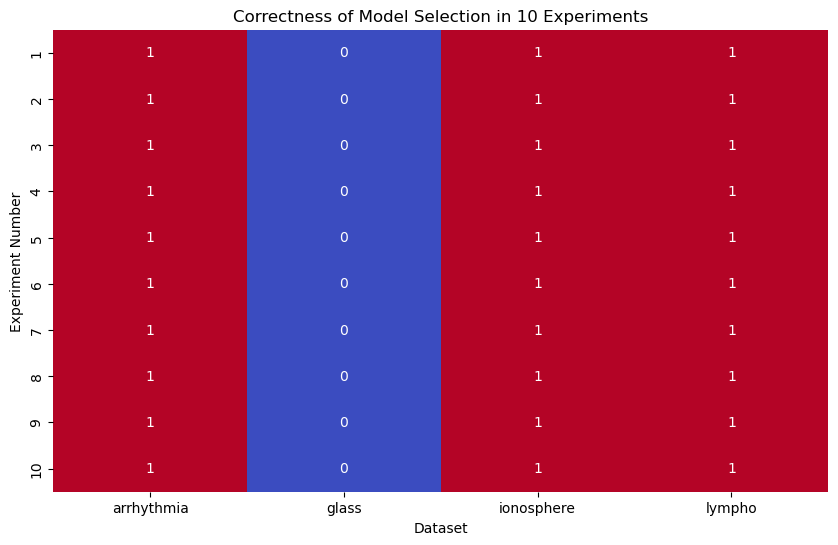

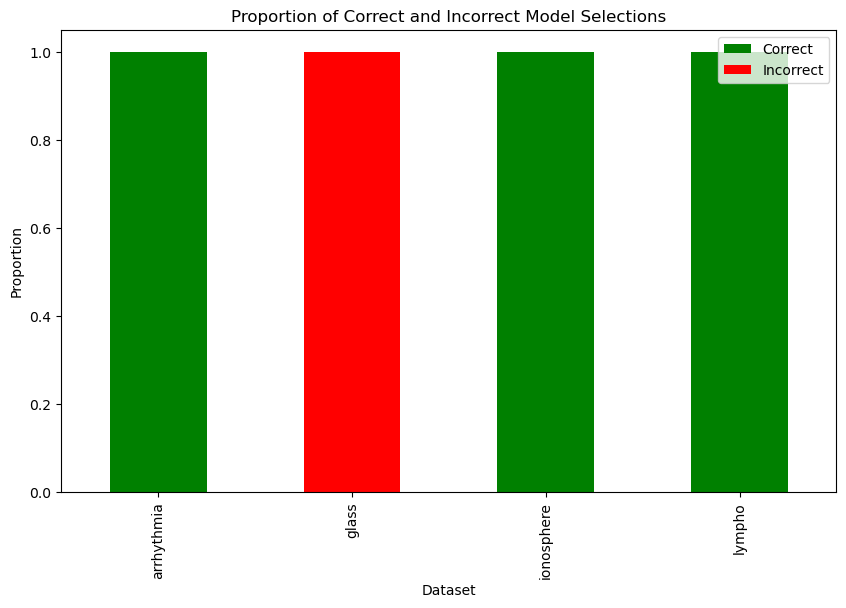

In [45]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Top 1 模型
top1_models = {
    'arrhythmia': 'LUNAR',
    'glass': 'MO-GAAL',
    'ionosphere': 'AutoEncoder',
    'lympho': 'AnoGAN'
}

correctness_matrix = resp_df.apply(lambda col: [top1_models[col.name] in top5_models_per_dataset[col.name] for model in col])

plt.figure(figsize=(10, 6))
sns.heatmap(correctness_matrix, annot=True, cmap='coolwarm', cbar=False)
plt.title('Correctness of Model Selection in 10 Experiments')
plt.xlabel('Dataset')
plt.ylabel('Experiment Number')
plt.show()

correct_counts = correctness_matrix.sum()
total_counts = correctness_matrix.count()
correct_ratios = correct_counts / total_counts
correctness_df = pd.DataFrame({
    'Correct': correct_ratios,
    'Incorrect': 1 - correct_ratios
})

correctness_df.plot(kind='bar', stacked=True, figsize=(10, 6), color=['green', 'red'])
plt.title('Proportion of Correct and Incorrect Model Selections')
plt.ylabel('Proportion')
plt.xlabel('Dataset')
plt.legend(['Correct', 'Incorrect'])
plt.show()


## Test: LLAMA